In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
# load data
r_data = pd.read_csv("../result/join_weather_flower/Rose_C0H960_草屯.csv")
r_data = r_data.dropna()
lc_data = pd.read_csv("../lunar_celeb_date.csv", encoding="utf-8")
r_data = r_data.join(lc_data.set_index("date"), on="Date")
r_data = r_data.reset_index()
r_data = r_data.drop(columns="index")
pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', 29)

# normalize and code dummy
data_t_n = ['Temperature', 'RH', 'StnPres', 'WS', 'WSGust','d_tmp']
data_t_n = []
data_to_dummy = ["week"]
col_fix =  ['T.Max', 'T.Min', 'Precp','Temperature', 'RH', 'StnPres', 'WS', 'WSGust']
# rm "/"
for col in col_fix:
    old = r_data[col]
    new = []
    for i in range(len(old)):
        try:
            new.append(float(old[i]))
            tmp = float(old[i])
        except ValueError:
            new.append(tmp)
    r_data[col] = new
    
rain  = r_data['Precp']
# rain_class function
def rain_c(precp):
    rain_class=[0]
    rain_tag = ["no_rain", "rain"]
    result = 0
    for d in rain_class:
        if precp>d:
            result = result + 1
    return result

rain_class=[]
for precp in rain:
    rain_class.append(rain_c(precp))
# df_r["rain_class"]=rain_class
# print("0,<5,>5",np.bincount(rain_class))
d_tmp = r_data['T.Max'] - r_data['T.Min']

d = np.array(r_data["Date"])
day_new=[]
for date in d:
    result =  "date_" + date.split("-")[-1]
    day_new.append(result)


y_raw = r_data["avg_price"]
y_tcount=r_data["total_count"]
# y_raw = y_tcount

drop_c =['Date','T.Max', 'T.Min', 'Precp','avg_price', 'total_count','year',
         "month","flower","StnPres","WSGust","WS",'Temperature',"RH"]
drop_c = drop_c + ['spring', 'mother', 'graduation', 'ghost']
r_data = r_data.drop(columns=drop_c)
# r_data["Monthdate"]= day_new
# r_data["rain"]= rain_class
# r_data["d_tmp"]= d_tmp


def to_zscore(df, col_x):
#     df_tmp = df
#     col = "Temperature"
    for col in col_x:
        df[col] = stats.zscore(df[col])
        df[col] = np.round(df[col], decimals=4)
# modify x p2
date_info = pd.DataFrame()
for col in data_to_dummy:
    date_info[col] = r_data[col]
    dummy =pd.get_dummies(date_info[col])
    date_info = pd.concat([date_info, dummy], axis=1)
    r_data = r_data.drop([col], axis = 1)
    date_info = date_info.drop([col], axis = 1)

c =r_data.columns.to_list()

to_zscore(r_data, data_t_n)
# modify y
y_pct  = np.array(y_raw.pct_change()[1:])
    

# -----------
r_data

,g_marry,g_pray,g_funeral,g_business,b_marry,b_pray,b_funeral,b_business,valetine_west,valetine_east
0,1,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,1,0,0
2,0,1,0,0,1,0,1,1,0,0
3,0,0,0,0,1,0,1,1,0,0
4,0,1,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1711,1,1,0,0,0,0,1,1,0,0
1712,0,1,0,0,0,0,0,0,0,0
1713,0,1,0,0,0,0,0,0,0,0
1714,0,0,0,0,0,0,0,0,0,0


In [2]:
c


['g_marry',
 'g_pray',
 'g_funeral',
 'g_business',
 'b_marry',
 'b_pray',
 'b_funeral',
 'b_business',
 'valetine_west',
 'valetine_east']

In [3]:
pd.DataFrame(y_pct).describe()

,0
count,1715.000000
mean,0.010842
std,0.155656
min,-0.552680
25%,-0.072417
50%,-0.001836
75%,0.081671
max,1.372380


In [4]:
def y_to_class(v):
    t = 0
    y_class_range = [-0.2,-0.1, 0, 0.1, 0.2]
    for i in range(len(y_class_range)):
        if (v >= y_class_range[i]):
            t = i+1
    return int(t)

y_class = []
for i in range(len(y_pct)):
    y_class.append(y_to_class(y_pct[i]))
print("freq:",np.bincount(y_class))
out_class_count = len(np.bincount(y_class))


freq: [ 89 216 567 491 219 133]


In [5]:
df_all = r_data.copy()
arr_all = np.array(df_all)
dfs =[]
print(len(arr_all))
shifts = 70
for i in range(1,shifts+1):
    df_s = r_data.copy()
    tp = np.array(df_s.shift(periods=i))
    arr_all = np.concatenate((arr_all, tp), axis=1)
arr_all = np.concatenate((arr_all, np.array(date_info)),axis=1)
df_all = pd.DataFrame(arr_all)
df_all = df_all.dropna()
df_all = df_all.reset_index()
df_all = df_all.drop(columns="index")
x = df_all
y = y_class[:(-shifts+1)]
# y = y_class[shifts-1:]
print(len(x),len(y))

1716
1646 1646


In [6]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

Using TensorFlow backend.


In [7]:
input_d  =x.shape[1]
input_d

763

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                30560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 246       
Total params: 30,806
Trainable params: 30,806
Non-trainable params: 0
_________________________________________________________________
Train on 1332 samples, validate on 149 samples
Epoch 1/10
 - 0s - loss: 1.6586 - acc: 0.2958 - val_loss: 1.5447 - val_acc: 0.3624
Epoch 2/10
 - 0s - loss: 1.6074 - acc: 0.3378 - val_loss: 1.5422 - val_acc: 0.3624
Epoch 3/10
 - 0s - loss: 1.5905 - acc: 0.3514 - val_loss: 1.5396 - val_acc: 0.3557
Epoch 4/10
 - 0s - loss: 1.5829 - acc: 0.3701 - val_loss: 1.5367 - val_acc: 0.3624
Epoch 5/10
 - 0s - loss

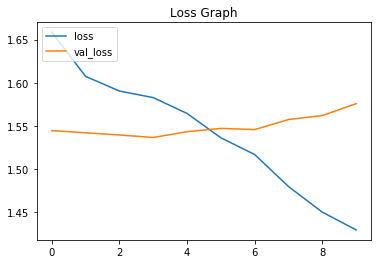

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
model = Sequential()
# layer_0 = Dense(units =40, input_dim = input_d,kernel_initializer = "random_normal",
#                 activation = "relu")
# model.add(layer_0)
layer_1 = Dense(units =40,input_dim = input_d,kernel_initializer = "random_normal",
                activation = "sigmoid")
model.add(layer_1)
model.add(Dropout(0.25))
# layer_2 = Dense(units =(input_d//100),kernel_initializer = "random_normal",
#                 activation = "relu")
# model.add(layer_2)
# model.add(Dropout(0.25))
layer_out = Dense(units = out_class_count,kernel_initializer = "random_normal",
                  activation = "softmax")
model.add(layer_out)
model.summary()
model.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
train_history = model.fit(x = x_train, y = np_utils.to_categorical(y_train),
                          validation_split = 0.1, epochs =10, verbose = 2)
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")

In [9]:
from sklearn.metrics import confusion_matrix
pre = model.predict_classes(x_test)
pd.DataFrame(confusion_matrix(y_test, pre))


,0,1,2,3,4,5
0,0,0,1,4,0,0
1,0,0,5,20,0,0
2,0,0,8,38,0,0
3,0,0,18,43,0,0
4,0,0,0,16,0,0
5,0,0,3,9,0,0
